# CNN - Object Detection - Part-1
#### • DOMAIN: 
> Entertainment
#### • CONTEXT: 
> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
#### • DATA DESCRIPTION: 
> The dataset comprises of images and its mask where there is a human face.
#### • PROJECT OBJECTIVE: 
>Face detection from training images.

# (1) Import Python libraries.

## (1.1) Import Python Libraries

In [494]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")


from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.backend import flatten,sum
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam



import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange, tqdm
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(2021)

You are using TensorFlow version 2.4.1
You have a GPU enabled.


## (1.2) Enable and Mount Google Drive

In [305]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## (1.3) Set directory paths

In [306]:
project_path = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_1'
image_file_path = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_1/Part 1- Train data - images.npy'
test_image = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_1/Part 1Test Data - Prediction Image.jpeg'

# (2) Load and preprocess Data

## (2.1) Load image data from the .npy file in the project path

In [307]:
data = np.load(image_file_path,allow_pickle=True)
data.shape

(409, 2)

#### Observations:
>1. There are 409 images and their corresponding masks.

## (2.1) Display sample data and it's masks

#### Images of shape (333, 650, 3)

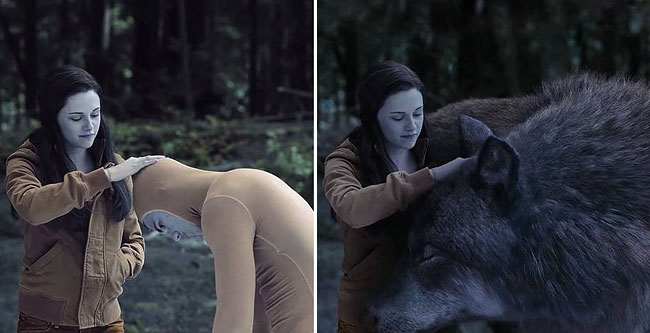

#### Mask data of shape 2 with contents :

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

In [308]:
display(Markdown(f"#### Images of shape {data[0][0].shape}"))
cv2_imshow(data[0][0])
display(Markdown(f"#### Mask data of shape {len(data[0][1])} with contents :"))
display(data[0][1])

#### Observations:
> 1. The image data has an image with 3 channels of size `333 X 650` as one of it's features i.e `[0]`.
> 2. The image data has attributes pertaining to `face` as another feature i.e `[1]`.

## (2.2) Verify if all images have 3 channels as required nby `MobileNet`

In [309]:
three_channel_img = 0
ind_counter = 1
for pics in enumerate(data):
  if len(pics[1][0].shape) < 3:
    display(Markdown(f"{ind_counter}) Image in index position **`{pics[0]}`** is **`GRAYSCALE`** with shape **{pics[1][0].shape}**"))
    ind_counter+=1
  elif (len(pics[1][0].shape) == 3) and (pics[1][0].shape[2] == 4):
    display(Markdown(f"{ind_counter}) Image in index position **`{pics[0]}`** may have **`ALPHA CHANNEL`** with shape **{pics[1][0].shape}**"))
    ind_counter+=1
  else:
    three_channel_img+=1
display(Markdown(f"{ind_counter}) Rest **`{three_channel_img}`** are **`RGB CHANNEL`** images"))


1) Image in index position **`1`** may have **`ALPHA CHANNEL`** with shape **(697, 1280, 4)**

2) Image in index position **`3`** may have **`ALPHA CHANNEL`** with shape **(291, 600, 4)**

3) Image in index position **`41`** may have **`ALPHA CHANNEL`** with shape **(340, 516, 4)**

4) Image in index position **`49`** may have **`ALPHA CHANNEL`** with shape **(600, 800, 4)**

5) Image in index position **`64`** may have **`ALPHA CHANNEL`** with shape **(312, 750, 4)**

6) Image in index position **`140`** may have **`ALPHA CHANNEL`** with shape **(330, 538, 4)**

7) Image in index position **`151`** may have **`ALPHA CHANNEL`** with shape **(496, 860, 4)**

8) Image in index position **`247`** may have **`ALPHA CHANNEL`** with shape **(379, 505, 4)**

9) Image in index position **`263`** may have **`ALPHA CHANNEL`** with shape **(400, 770, 4)**

10) Image in index position **`272`** is **`GRAYSCALE`** with shape **(350, 650)**

11) Image in index position **`337`** may have **`ALPHA CHANNEL`** with shape **(267, 740, 4)**

12) Image in index position **`347`** may have **`ALPHA CHANNEL`** with shape **(281, 600, 4)**

13) Rest **`397`** are **`RGB CHANNEL`** images

#### Observations:
> 1. There are `12` images with `4` channels and one with `2` channels.
> 2. Rest 397 images 3 channels i.e `RGB` channels.
> 3. Image in the index position `272` seems like an outlier i.e a `grayscale` image. We might need to convert this to `RGB` scheme before training the model.

## (2.3) Set the global parameters for the image i.e Height, Width and number of Channels.

In [310]:
IMAGE_HEIGHT, IMAGE_WIDTH,NUM_CHANNELS = 224,224,3

## (2.4) Read all images and masks into numpy arrays.

In [483]:

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    # assign all pixels in the first 3 channels only to the image, i.e discard the alpha channel
    try:
      img = img[:, :, :3]
    except:
      print(f"Exception {index} GARYSCALE image with shape  {img.shape}")
      # convert the grayscale image to color so that the number of channels are standardised to 3 
      img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    # Loop through the face co-ordinates and create mask out of it. 
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        # Set all pixels within the mask co-ordinates to 1.
        masks[index][y1:y2, x1:x2] = 1

display(Markdown(f"#### Shape of X is `{X.shape}` and the shape of mask is `{masks.shape}`"))


Exception 272 GARYSCALE image with shape  (224, 224)


#### Shape of X is `(409, 224, 224, 3)` and the shape of mask is `(409, 224, 224)`

#### Observations:
> 1. All 409 images are resized to shape of`(224 X 224 X 3)` are held in the variable `X`and their corresponding masks resized to the shape of `(224 X 224)`.
> 2. The image even includes the one index position `272` which is a grayscale image.

## (2.5) Helper function to test the image and it's mask

In [312]:
def test_image_mask(X,mask,alpha=0.5):

  fig, ax = plt.subplots(1,3,figsize=(18,6))
  ax[0].imshow(X)
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[0].set_title("Image",{'fontsize':20})
  
  ax[1].imshow(mask)
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[1].set_title("Mask",{'fontsize':20})

  ax[2].imshow(X)
  ax[2].imshow(mask,alpha=alpha)
  ax[2].set_xticks([])
  ax[2].set_yticks([])
  ax[2].set_title("Mask superposed on Image",{'fontsize':20})

  plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


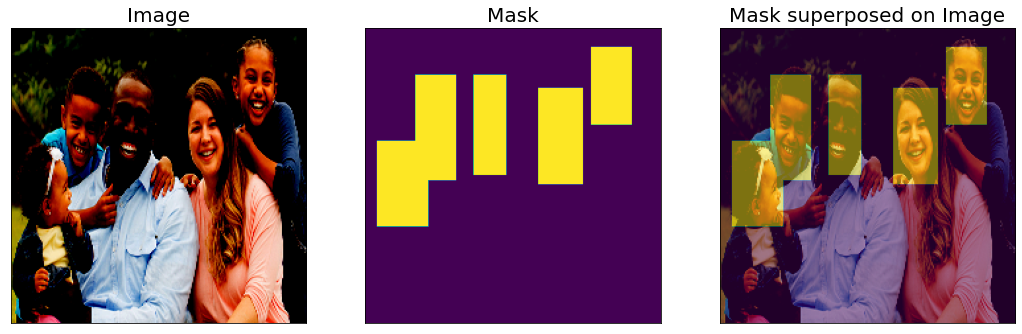

In [313]:
test_image_mask(X[140],masks[140])

#### Observations:
> 1. The image and it's corresponding mask is correctly displayed.
> 2. The mask is correctly superposed on the image. This means both image and it's mask is correstly sized and created. 

## (2.6) Train, Test and Split images

In [314]:
from sklearn.model_selection import train_test_split

X_train,X_test,mask_train,mask_test = train_test_split(X,masks,test_size=0.2)

display(Markdown(f"#### Shape of X_train is `{X_train.shape}` and mask_train is `{mask_train.shape}`"))
display(Markdown(f"#### Shape of X_test is `{X_test.shape}` and mask_test is `{mask_test.shape}`"))


#### Shape of X_train is `(327, 224, 224, 3)` and mask_train is `(327, 224, 224)`

#### Shape of X_test is `(82, 224, 224, 3)` and mask_test is `(82, 224, 224)`

#### Observations:
> 1. Training set contains `327` resized imagesm and it's masks.
> 2. Test set is `20%` of the entire image i.e `82` images and it's masks

## (2.7) Display images from train and test set 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


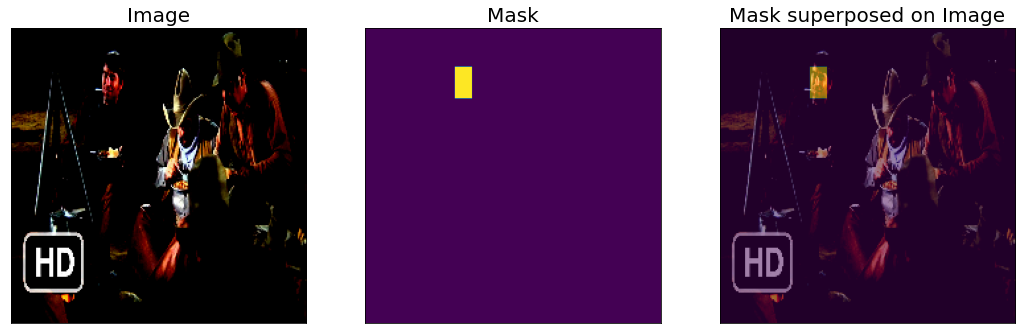

In [315]:
test_image_mask(X_train[10],mask_train[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


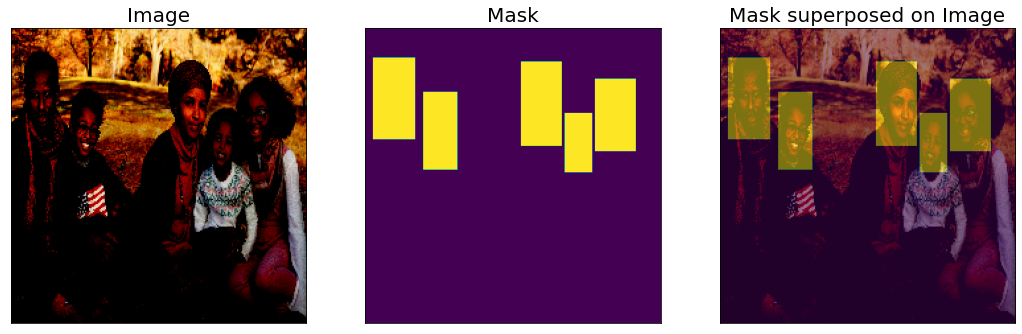

In [316]:
test_image_mask(X_test[10],mask_test[10])

#### Observation:
> 1. Both Train and test set images are correctly displayed with their masks correstly superposed on them.

# (3) Modelling

## (3.1) Set tglobal parameters for modelling.

In [452]:
n_epochs = 100
batch_size = 10

## (3.2) Create a helper class to live plot the training progress.

In [453]:
class LivePlot(tf.keras.callbacks.Callback):
    
    def __init__(self,refresh_rate=5,train_loss=None,train_metric=None):
        self.validation_prefix = "val_"
        self.refresh_rate = refresh_rate
        self.train_loss = train_loss
        self.val_loss = self.validation_prefix + train_loss
        self.train_metric = train_metric
        self.val_metric = self.validation_prefix + train_metric
        
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.train_losses = []
        self.train_metrics = []
        self.val_losses = []
        self.val_metrics = []
        
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculates and plots loss and metrics
        """
        # Extract from the log
        log_train_loss = logs.get(self.train_loss)
        log_train_metric = logs.get(self.train_metric)
        log_val_loss = logs.get(self.val_loss)
        log_val_metric = logs.get(self.val_metric)
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.train_losses.append(log_train_loss)
        self.train_metrics.append(log_train_metric)
        self.val_losses.append(log_val_loss)
        self.val_metrics.append(log_val_metric)
        
        # Plots every nth epoch
        if epoch > 0 and epoch%self.refresh_rate == 0:
            fig, ax = plt.subplots(1,2,figsize=(20,6)) 
            clear_output(wait=True)
            N = np.arange(0, len(self.train_losses))
            
            sns.lineplot(x=N,y=self.train_losses,ax=ax[0],legend='brief',label=self.train_loss)
            sns.lineplot(x=N, y = self.val_losses,ax=ax[0],legend='brief',label=self.val_loss)
            ax[0].set_title('Loss over Epoch',{'fontsize':20})
            # ax[0].set_title(f'Loss over Epoch {epoch} - {log_train_loss:.3}/{log_val_loss:.3} - (T/V)\n',{'fontsize':20})
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel(self.train_loss)
            
            sns.lineplot(x=N,y=self.train_metrics,ax=ax[1],legend='brief',label=self.train_metric)
            sns.lineplot(x=N,y=self.val_metrics,ax=ax[1],legend='brief',label=self.val_metric)
            ax[1].set_title('Performance over Epoch ',{'fontsize':20})
            # ax[1].set_title(f'Performance over Epoch {epoch} - {log_train_metric:.3}/{log_val_metric:.3} - (T/V) \n',{'fontsize':20})
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel(self.train_metric)
            plt.show()
            

## (3.3) Function to create a `UNet` model out of `MobileNet` using Transfer Learning method.

In [454]:
def create_unet_model(shape,trainable=True):
    # IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    #ref https://keras.io/applications/#mobilenet
    model = MobileNet(input_shape=shape, alpha = 1.0, include_top=False, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #ref https://stackoverflow.com/questions/59154560/how-can-i-feed-the-output-from-last-layer-of-mobilenet-to-a-unet-model
    # block0 = model.get_layer("conv_pw_1_relu").output 
    # print(block0)
    block = model.get_layer("conv_pw_1_relu").output
    # print(block)
    block1 = model.get_layer("conv_pw_3_relu").output
    # print(block1)
    block2 = model.get_layer("conv_pw_5_relu").output
    # print(block2)
    block3 = model.get_layer("conv_pw_11_relu").output
    # print(block3)
    block4 = model.get_layer("conv_pw_13_relu").output
    # print(block4)

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
 #   x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    
    return Model(inputs=model.input, outputs=x)

## (3.4) Function to create custom metric for the use case i.e `Dice Coefficient`.

In [455]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

## (3.5) Function to create custom loss fucntion using `binary_crossentropy` using `Dice Coefficient`



In [456]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

## (3.6) callback fucntions for `Model Chekpointing`, `Live Plotting`, `Early Stopping` and `LR Reduction on plateau`.

In [457]:

checkpoint = ModelCheckpoint(f'{project_path}/model_'+'{loss:.2f}.h5', 
                             monitor="loss", 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True, 
                             mode="min", 
                             )

liveplot = LivePlot(1,train_loss='loss',train_metric='dice_coefficient')
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

## (3.7) Create the UNet model and display the stack.

In [458]:
model = create_unet_model((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_18[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
___________________________________________________________________________________________

In [489]:
display(Markdown(f"#### There are {len(model.layers)} layers in this model"))

#### There are 97 layers in this model

#### Observations:
> 1. There are 97 layers to be trained in the model that incliudes `Input`, `Hidden Conv ` and `output` layers.
> 2. There are close `3.2M` trainable parameters in the model.
> 3. The model uses the a `contraction block` enabled through `MaxPooling` that contracts the `(224 X 224 X 3)` image down to `(7 X 7 X 1024)`.
> 4. The `expansive block` generates the mask from the learnt image of size `(224 X 224)`.

##(3.8) Confirm the input and output image size

In [459]:
model.input_shape, model.output_shape

((None, 224, 224, 3), (None, 224, 224))

## (3.9) Define optimizer and compile the model

In [460]:
adam = Adam(learning_rate=0.001) #learning_rate=0.001
model.compile(adam, loss=loss, metrics=[dice_coefficient])

## (3.10) Fit and build the model

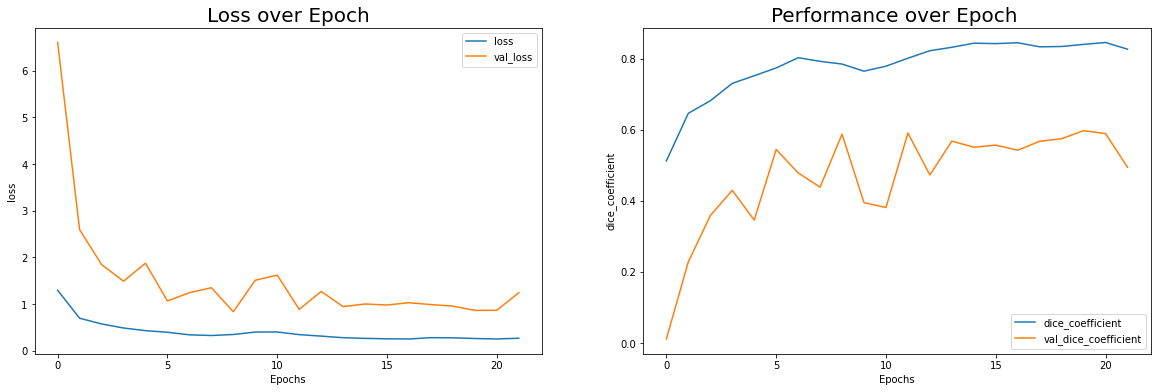


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


In [461]:
history = model.fit(x=X_train, 
                    y=mask_train, 
                    batch_size=batch_size, 
                    epochs=n_epochs, 
                    verbose=0, 
                    callbacks=[checkpoint,liveplot,reduce_lr, stop], 
                    validation_split=0.2, 
                    workers=1, 
                    use_multiprocessing=True
                    )

#### Observations:
>1. As we see the training loss is lesser when compared to the validation loss.

#(4) Model Testing - Use the pretrained weights

## (4.1) Model Evalaution

In [501]:
weight_file = os.path.join(project_path,'model_0.23.h5')
model.load_weights(weight_file)

In [502]:
model.evaluate(X_test,mask_test,batch_size=batch_size)

9/9 [==============================] - 1s 109ms/step - loss: 0.8733 - dice_coefficient: 0.5970


[0.8733379244804382, 0.597031831741333]

#### Observations:
> 1. We have used the best weights from those checkpointed during the training process.
> 2. The model has given us a performance of 59% on the test image set.

## (4.2) Model Testing

### (4.2.1) Test the model on an image from the test set.

## <center>Predicted Image Mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


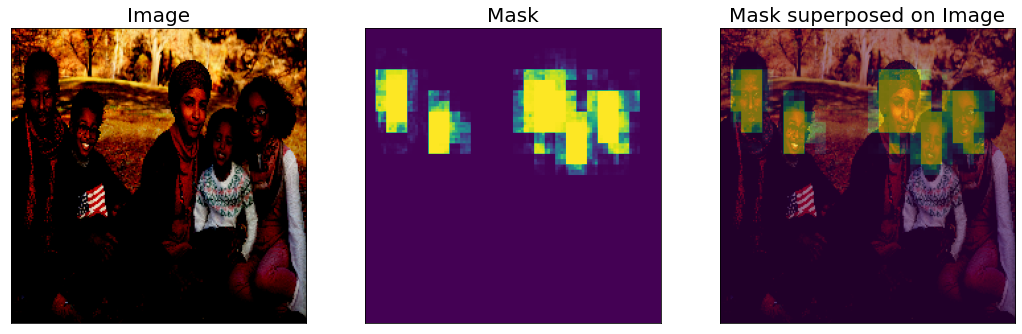

## <center>Actual Image Mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


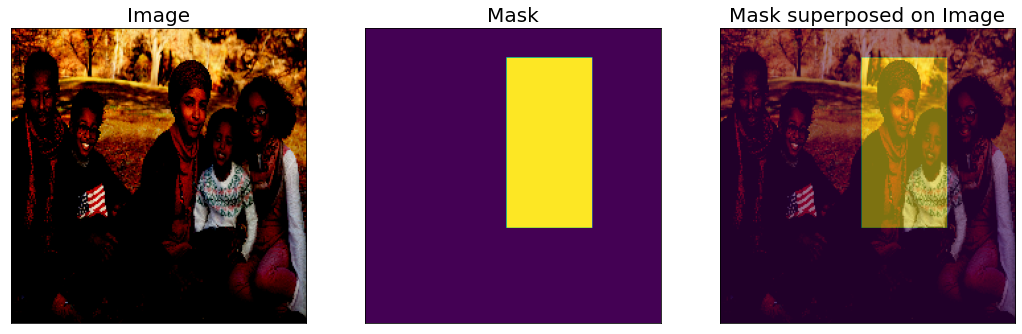

In [500]:
tst_index = 10
test_pred_mask = model.predict(np.resize(X_test[tst_index],(1,IMAGE_HEIGHT,IMAGE_WIDTH,NUM_CHANNELS)))
test_pred_mask = np.squeeze(test_pred_mask,axis=0)

display(Markdown("## <center>Predicted Image Mask "))
test_image_mask(X_test[tst_index],test_pred_mask)
display(Markdown("## <center>Actual Image Mask "))
test_image_mask(X_test[tst_index],masks[tst_index])


#### Observation:
> 1. Comparing the `predicted` and `actual` mask, we find that the model has successfully detected all faces in the image.

##(4.3) Predicting mask for an unseen image or an image without a mask.

###(4.3.1) Load and pre-process the image file.

#### The original test image shape is (500, 500, 3)

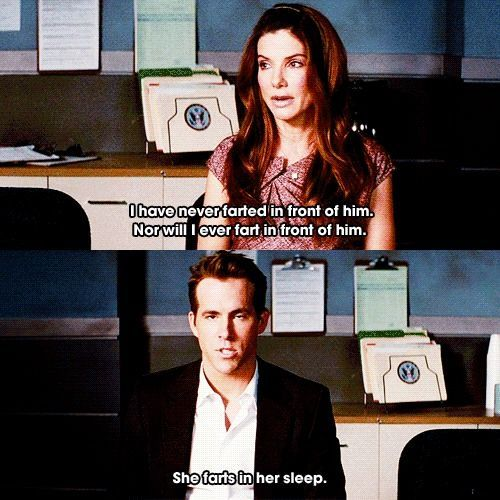

#### The test image shape after resizing is (224, 224, 3)

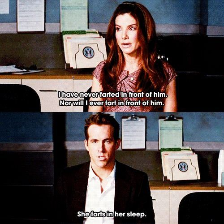

#### The shape of the predicted mask is of shape (224, 224)

In [480]:
tst_img = cv2.imread(test_image)
display(Markdown(f"#### The original test image shape is {tst_img.shape}"))
cv2_imshow(tst_img)
tst_img = cv2.resize(tst_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
display(Markdown(f"#### The test image shape after resizing is {tst_img.shape}"))
cv2_imshow(tst_img)

feat_scaled = preprocess_input(np.array(tst_img, dtype=np.float32))
# pred_mask = model.predict(x=np.array([feat_scaled]))[0] > 0.5
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

display(Markdown(f"#### The shape of the predicted mask is of shape {pred_mask.shape}"))

#### Observation:
> 1. The Image correctly resized to `(224 X 224 X 3)` and pre-processed to be consumed by the model.
> 2. The predicted mask has a shape of `(224 X 224 )`.
> 3. We will now superpose the predicted mask on the image to verify if they really cover faces in the image.

## (4.4) The final step - Superpose the mask and verify it it's faces.

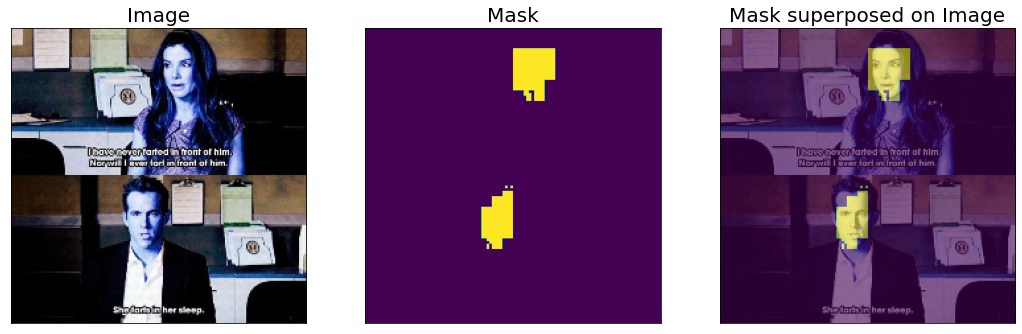

In [481]:
test_image_mask(tst_img,pred_mask,alpha=0.6)

#### Observations:
> 1. The predicted masks correctly superpose on the image. That means that the model has correctly been able to segment faces in the image.

# (5) Conclusion

> 1. We have imported , loaded and preprocessed images as required by the MobileNet to segment face/s off the image.
> 2. We have successfully used transfer learning method using `MobileNet` to train the model on set of images containing face/s and their masks.